<h1 align="center">GPR Hyperparameters</h1>

## Purpose Of Notebook

The Gaussian Process Regressor (GPR) algorithm heavily relies on initial hyperparameter values to begin its optimization process. If these initial guesses are poor, the model can fail to converge or get stuck in a bad local minimum, leading to an incorrect fit. To use GPR in an automated pipeline for various signals, we cannot manually tune these parameters each time. Therefore, we must programmatically approximate, or "guess," these hyperparameters based on the incoming signal's properties.

This is achieved using statistical heuristics, such as analyzing the signal after masking out the spectral lines. By isolating the baseline, we can intelligently estimate parameters like noise_level from the high-frequency variations and length_scale from the baseline's overall smoothness. This automated estimation provides a robust starting point and bounds, ensuring the GPR can reliably model the background.

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## Create Background Function

In [176]:
def background_creation(freq , is_polyonimal , is_sin , noise_level ):

    # --- Creation of Noise ---
    noise = np.zeros(freq.shape)
    if noise_level == "High":
        noise = np.random.normal(0 , 0.7 , freq.shape)
    elif noise_level == "Medium":
        noise = np.random.normal(0 , 0.5 , freq.shape)
    elif noise_level == "Low":
        noise = np.random.normal(0 , 0.2 , freq.shape)    

    #  --- Creation of Baseline ---
    # is_polyonimal = True -> signal = a(frequencies - 1420)^2 + b
    # is_sin = True -> signal = A* sin (ω  * (frequencies - 1418) + phase) 
    # is_both = True -> signal = polyonimal + sin
    signal = np.zeros(freq.shape)    
    if(is_polyonimal == True):
        a = np.random.uniform(low=-0.5 , high = 1)
        b = np.random.uniform(low=3 , high = 7)
        signal+= a * (freq-1420)**2 + b
    if(is_sin == True):
        A = np.random.uniform(0.5 , 1)
        omega = 2 * np.pi * np.random.uniform(low = 0.2 , high = 0.8)
        phase = np.random.uniform(low = 0 , high = 2*np.pi)
        signal += A * np.sin(omega*(freq-1418) + phase)

    return noise , signal + noise    


## noise_level & noise_bounds Approach

We will create 1000 different signals.200 of them will have low noise , 300 of them will have medium noise and 500 will have high noise.We will check if the noise approach was succesfull or not

### The Noise Estimation Method:

The method we are using, 'np.median(np.abs(np.diff(y_signal))) ' , is a robust statistical heuristic designed to estimate the standard deviation ($\sigma$) of the high-frequency "white noise" in a signal, even when that noise is superimposed on a changing baseline.

### The Error Estimation Pipeline

Here is a concise summary of my analysis pipeline:

To evaluate the performance of the noise estimation method, I analyzed the data from 1,000 simulations.

First, I calculated the overall average percentage error across all runs to get a single, top-level performance metric.

Next, to understand the method's specific strengths and weaknesses, I grouped the results by the two experimental variables: the signal_type (e.g., Polynomial, Sinusoidal) and the noise_level (Low, Medium, High). I then calculated the mean percentage error for each specific combination (e.g., the average error for all "Polynomial" + "Low Noise" runs).

Finally, I organized this 2D matrix of errors and plotted it as a heatmap. This visualization makes it easy to immediately identify which types of background signals or noise levels cause the estimation method to perform poorly (high error) versus where it succeeds (low error).

Execute 1000 simulations...


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 6719.80it/s]

Simulation Complete!

--- Total performance of  noise estimation---
 Average Percentage Error: 4.94%



--- Mean Percantage Error per Category --- 
noise_level       Low    Medium      High
signal_type                              
Poly+Sine    5.190610  4.607272  4.800071
Polynomial   4.995013  5.292011  5.363076
Sinusoidal   4.674969  4.810497  4.946165


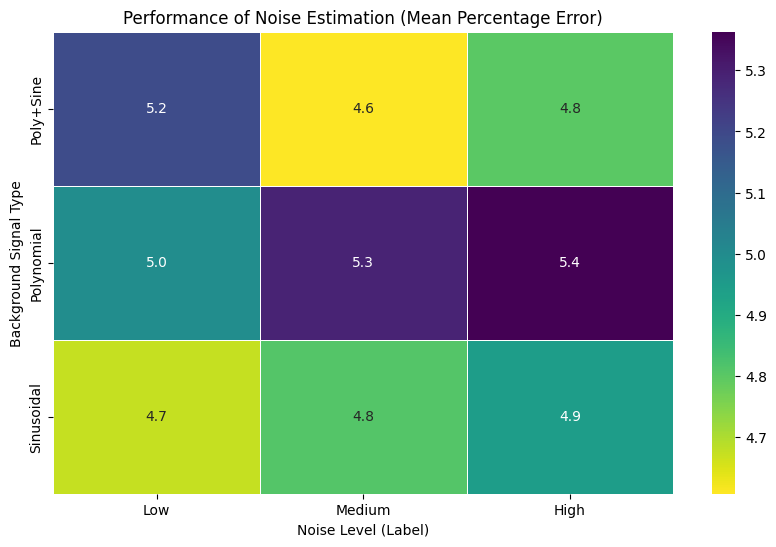

In [177]:
frequencies = np.linspace(1418,1422,1024)
runs = 1000

#create the "schedule" for the noise level
noise_levels = ["Low"]*200 + ["Medium"]*300 + ["High"]*500
np.random.shuffle(noise_levels)

results = [] # list to save the results

# --- Simulation Procces Implementation ---
print(f"Execute {runs} simulations...")
for i in tqdm(range(runs)):
    noise_level_label = noise_levels[i] 

    # Random selection of the background
    is_poly = np.random.choice([True,False])
    is_sin = np.random.choice([True,not is_poly]) # delete the case where both is false

    true_noise , y_observed = background_creation(frequencies,is_poly,is_sin,noise_level_label)

    true_noise_std = np.std(true_noise) 

    # --- Noise std Approach ---
    noise_guess = np.median(np.abs(np.diff(y_observed)))
    
    error = np.abs(noise_guess-true_noise_std)
    if true_noise_std>0:
        error_percent = (error/true_noise_std)*100

    # Label for the heatmap
    if is_poly and is_sin:
        signal_type_label = "Poly+Sine"
    elif is_poly:
        signal_type_label = "Polynomial"
    else:
        signal_type_label = "Sinusoidal"

    results.append({
        "noise_level": noise_level_label,
        "signal_type": signal_type_label,
        "error_percent": error_percent,
        "true_std": true_noise_std,
        "guessed_std": noise_guess
    })

print("Simulation Complete!")
results_df = pd.DataFrame(results)

# Total Performance
print("\n--- Total performance of  noise estimation---")
print(f" Average Percentage Error: {results_df['error_percent'].mean():.2f}%")

# Creation of the array for the heatmap
heatmap_data = results_df.groupby(['signal_type' , 'noise_level'])['error_percent'].mean().unstack()
heatmap_data = heatmap_data[['Low' , 'Medium' , 'High']]

print("\n--- Mean Percantage Error per Category --- ")
print(heatmap_data)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="viridis_r", linewidths=.5)
plt.title("Performance of Noise Estimation (Mean Percentage Error)")
plt.xlabel("Noise Level (Label)")
plt.ylabel("Background Signal Type")
plt.show()
